In [1]:
import os
import re
import random
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import pickle
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.collections import Counter
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

**1. Load the given dataset**

In [2]:
corpus_path = os.path.abspath('/content/vaccine_train_set.csv')
print("Uploading dataset...")
data_df = pd.read_csv(corpus_path,header= None, names =["Tweet", "Label"])
print("Creating Pandas Dataframe...")
print("Dataframe is ready!")
class_names = [0,1,2]


data_df.head()

Uploading dataset...
Creating Pandas Dataframe...
Dataframe is ready!


,Tweet,Label
NaN,tweet,label
0.0,Sip N Shop Come thru right now #Marjais #Popul...,0
1.0,I don't know about you but My family and I wil...,1
2.0,@MSignorile Immunizations should be mandatory....,2
3.0,President Obama spoke in favor of vaccination ...,0


In [3]:
#download nltk modules (for google colab)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**2. Preprocess the text**



1.   Remove tags
2.   Remove characters
3.   Remove emoticons (for Twitter dataset)
4.   Lowercasing text
5.   Remove numbers (worthless objects)
6.   Remove stopwords




In [4]:
# Fill the NaN values with "NULL"
data_df.fillna('NULL', inplace=True)

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
                
        TAG_RE = re.compile(r'<[^>]+>_-@')
        no_tags = TAG_RE.sub('',text) 
        text = re.sub('<[^>]*>_@-', '', no_tags)        
        text = re.sub('_','',text) 
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
        text = re.sub('[\W]+', ' ', text.lower()) + " ".join(emoticons).replace('-', '')
        text = re.sub(r'\d+', '', text)

        return text

def remove_stopwords(text):

    text = nltk.word_tokenize(text)
    text = [w for w in text if not w in stop_words]
    text= ' '.join(text)
      
    return text


stemmer=PorterStemmer()
#stemmer=LancasterStemmer()

def stemming_tokenizer(str_input):

     words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
     words = [porter_stemmer.stem(word) for word in words]
     words.reshape(-1,1)

     return words
 

data_df['Tweet']=data_df['Tweet'].apply(preprocess_text)
print("Processing is ready!!")

data_df['Tweet']=data_df['Tweet'].apply(remove_stopwords)
print("Stopwords are removed!!")
text= data_df['Tweet']

data_df.head()


Processing is ready!!
Stopwords are removed!!


,Tweet,Label
NaN,tweet,label
0.0,sip n shop come thru right marjais popularnobo...,0
1.0,know family take covid vaccine anytime soon,1
2.0,msignorile immunizations mandatory period okla...,2
3.0,president obama spoke favor vaccination childr...,0


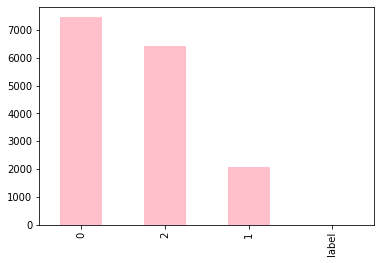

In [5]:
#plot counts of y values (labels)
data_df['Label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

**4. Vectorize text data with TF-IDF vectorizer**

In [6]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          


X_train= data_df['Tweet']
y_train= data_df['Label']


#vectorizer = CountVectorizer(min_df=2)
vectorizer = TfidfVectorizer(ngram_range=(1,2))

x_train = vectorizer.fit(X_train)
x_train = x_train.transform(X_train)
print("Vectorizing is ready!!")


vectorizer.vocabulary_
print(vectorizer.vocabulary_)
#vectorizer.get_feature_names()

#save tf-idf vectorizer
pickle.dump(vectorizer, open('tfidf_vectorizer.p', 'wb'))



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**5. Train the model using Softmax Regression**

In [7]:
def train(matrix,labels):
    
    softReg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter=100)
    softReg.fit(x_train,y_train)

    print('Model is ready!')

    softReg.intercept_,softReg.coef_

    filename = 'softRegr_model.sav'
    pickle.dump(softReg, open(filename, 'wb'))
 
train(x_train,y_train)


Model is ready!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


**6. SAVE THE MODEL**

In [8]:
filename="softRegr_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))
print('Model loaded!')

Model loaded!


**PLOT LEARNING CURVES WITH SKLEARN**

In [9]:
def Learning_curve_model(X, Y, model, cv):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

**8.PREDICTION & EVALUATION ON TEST SET**

Uploading dataset...
Vectorizing is ready!!
Prediction is ready!!
---------------------------
Precision for test set:
 0.5529044180976361
---------------------------
Recall for test set:
 0.4926789893187218
---------------------------
F1 score for test set:
 0.5077844124303713
---------------------------
Accuracy for test set:
 0.7367498904949628
---------------------------
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1065
           1       0.73      0.39      0.51       296
           2       0.67      0.82      0.74       921
       label       0.00      0.00      0.00         1

    accuracy                           0.74      2283
   macro avg       0.55      0.49      0.51      2283
weighted avg       0.74      0.74      0.73      2283

---------------------------
Loading for train set...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: 

---------------------------
Loading for confusion Matrix...


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


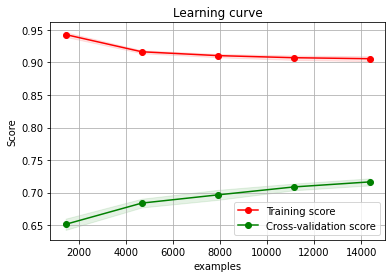

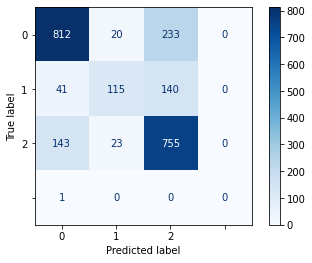

In [10]:
path = os.path.abspath('vaccine_validation_set.csv')
print("Uploading dataset...")

dataframe = pd.read_csv(path,header= None, names =["Tweet", "Label"]) 


#processing step
dataframe.fillna('NULL', inplace=True)
dataframe['Tweet']=dataframe['Tweet'].apply(preprocess_text)
dataframe['Tweet']=dataframe['Tweet'].apply(remove_stopwords)
    
text_test= dataframe['Tweet']
X_test= dataframe['Tweet']
y_test= dataframe['Label']

#vectorize test set
vectorizer = pickle.load(open('tfidf_vectorizer.p', 'rb'))
x_test = vectorizer.transform(X_test)
#x_test= x_test.todense()
print("Vectorizing is ready!!")

#make predictions
predictions = loaded_model.predict(x_test)
print("Prediction is ready!!")
print("---------------------------")


#metrics
precision = metrics.precision_score(y_test, predictions, average="macro")
print("Precision for test set:\n", precision)
print("---------------------------")

    
recall = metrics.recall_score(y_test, predictions, average="macro")
print("Recall for test set:\n", recall)
print("---------------------------")


fscore = metrics.f1_score(y_test, predictions, average="macro")
print("F1 score for test set:\n", fscore)
print("---------------------------")


acc = metrics.accuracy_score(y_test, predictions)
print("Accuracy for test set:\n", acc)
print("---------------------------")


#plot classification report from sklearn Library
print(classification_report(y_test, predictions))
print("---------------------------")


#visualize learning curves with 10fold cross validation
print("Loading for train set...")
Learning_curve_model(x_train,y_train,loaded_model,cv=10)
print("---------------------------")

#print("Loading for test set...")
#Learning_curve_model(x_test,y_test,loaded_model,cv=10)


#plot multiclass confusion matrix
print("Loading for confusion Matrix...")
disp = plot_confusion_matrix(loaded_model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
